# Compute association between rs2066807 and *STAT2* expression

This code fits the association between rs2066807 and *STAT2* expression using a linear model with principal covariates to determine the p-value of association. FDR was then calculated using the Benjamini-Hochberg test and gene expression was plotted.

Genotype and expression data from:
* Fairfax BP et al. Innate immune activity conditions the effect of regulatory variants upon monocyte gene expression. *Science* 2014 **343**:1246949.

---

First, the following R code was used to fit the linear model and calculate p-values of coefficients.

```r
library(tidyverse)
library(genio)
library(data.table)

## Load data
expr <- read_csv('all_expression_*.csv')  # where * refers to IFN/LPS2/LPS24/CD14(naive)
fairfax <- read_plink('extreme_response/extreme_response')
geno <- as.data.frame(fairfax$X)

# Drop samples without expression data
geno2 <- geno[, colnames(geno) %in% colnames(expr)]
# Convert rownames to column
geno2 <- tibble::rownames_to_column(geno2, "id")

# Compute pca
pca <- prcomp(t(expr[-1]), center=TRUE, scale = TRUE)
pc <- pca$x
plot(pca, npcs=10)

# Fit model with PC covariates
data <- data.frame(probe=unlist(subset(expr, expr$X1 == "130519")[-1]), 
                   rs2066807=unlist(subset(geno2, geno2$id == "rs2066807")[-1]), pc[,1:10])
pcFit <- lm(probe ~ ., data=data)
summary(pcFit)
summary(pcFit)$coefficients[,4]
```

---

The p-values of the coefficients were then inputted into Python to calculate FDR:

In [1]:
from statsmodels.sandbox.stats.multicomp import multipletests

p_ifn = [0.000000e+00, 5.456715e-01, 3.037571e-10, 9.506509e-02, 9.720181e-03, 1.919006e-03, 6.769681e-06,
         2.479601e-32, 6.272998e-02, 2.848666e-13, 6.523003e-05, 2.800248e-04]
fdr = multipletests(p_ifn, method='fdr_bh')
print('IFN: P=' + str(p_ifn[1]) + ', FDR= ' + str(fdr[1][1]))

p_naive = [0.000000e+00, 2.659463e-01, 3.715263e-21, 4.521052e-07, 3.142194e-02, 1.018633e-03, 3.730789e-30,
           1.302526e-01, 3.531167e-02, 5.839703e-06, 1.090417e-01, 9.717169e-65]
fdr = multipletests(p_naive, method='fdr_bh')
print('Naive: P=' + str(p_naive[1]) + ', FDR= ' + str(fdr[1][1]))

p_lps2 = [0.000000e+00, 7.185951e-11, 6.978101e-05, 7.190994e-02, 1.749982e-14, 3.375437e-25,
          1.460486e-32, 3.837525e-01, 4.161636e-11, 8.168696e-14, 4.192173e-16, 7.181122e-02]
fdr = multipletests(p_lps2, method='fdr_bh')
print('LPS2: P=' + str(p_lps2[1]) + ', FDR= ' + str(fdr[1][1]))

p_lps24 = [0.000000e+00, 1.372707e-07, 1.733594e-123, 5.449533e-89, 6.525651e-27, 9.907503e-10,
           1.013615e-49, 5.706853e-26, 5.341836e-08, 4.226239e-31, 6.679636e-30, 4.954350e-11]
fdr = multipletests(p_lps24, method='fdr_bh')
print('LPS24: P=' + str(p_lps24[1]) + ', FDR= ' + str(fdr[1][1]))

IFN: P=0.5456715, FDR= 0.5456715
Naive: P=0.2659463, FDR= 0.2659463
LPS2: P=7.185951e-11, FDR= 1.07789265e-10
LPS24: P=1.372707e-07, FDR= 1.372707e-07


---

Finally, *STAT2* gene expression was plotted for rs2066807:

In [2]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import isnan
from plinkio import plinkfile
sns.set()
%matplotlib inline

In [3]:
# Load genotype data
plink_file = plinkfile.open("extreme_response/extreme_response")
sample_list = plink_file.get_samples()
locus_list = plink_file.get_loci()

# Load expression data
expr_info = pd.read_csv('expression_info.csv', index_col=0)
expr_Naive = pd.read_csv('all_expression_CD14.csv', index_col=0)
expr_IFN = pd.read_csv('all_expression_IFN.csv', index_col=0)
expr_LPS2 = pd.read_csv('all_expression_LPS2.csv', index_col=0)
expr_LPS24 = pd.read_csv('all_expression_LPS24.csv', index_col=0)

# Intersecting SNPs in Neanderthal & Fairfax datasets
comparison_df = pd.read_csv("../neanderthal/allpop_fixed.csv", usecols=['Chromosome', 'Position', 'Source', 'Major'])
extr_resp = pd.read_csv("tab2_a_cis_eSNPs.txt", sep="\t",
                        usecols=["SNP", "Gene", "SNP.Chrm", "SNP.pos", "Min.dataset", "LPS2.p.value", "LPS24.p.value",
                                 "IFN.p.value", "Naive.p.value", "LPS2.FDR", "LPS24.FDR", "IFN.FDR", "Naive.FDR"])
extr_resp = extr_resp.rename(columns={"SNP.Chrm": "Chromosome", "SNP.pos": "Position", "SNP": "ID"})
extr_resp_df = comparison_df.merge(extr_resp, how='left', on=['Chromosome', 'Position'])
extr_resp_df = extr_resp_df.dropna(subset=['ID'])

# Subset intersecting SNPs by treatment groups
# IFN
ifn = extr_resp_df.loc[extr_resp_df['Min.dataset'] == "IFN"].copy()
ifn.drop(columns=["LPS2.p.value", "LPS24.p.value", "Naive.p.value", "LPS2.FDR", "LPS24.FDR", "Naive.FDR"], inplace=True)
ifn.rename(columns={"IFN.p.value": "p.value", "IFN.FDR": "FDR"}, inplace=True)
ifn = ifn.sort_values('p.value').drop_duplicates(subset=['Gene', 'ID'], keep='first')

# LPS2
lps2 = extr_resp_df.loc[extr_resp_df['Min.dataset'] == "LPS2"].copy()
lps2.drop(columns=["IFN.p.value", "LPS24.p.value", "Naive.p.value", "IFN.FDR", "LPS24.FDR", "Naive.FDR"], inplace=True)
lps2.rename(columns={"LPS2.p.value": "p.value", "LPS2.FDR": "FDR"}, inplace=True)
lps2 = lps2.sort_values('p.value').drop_duplicates(subset=['Gene', 'ID'], keep='first')

# LPS24
lps24 = extr_resp_df.loc[extr_resp_df['Min.dataset'] == "LPS24"].copy()
lps24.drop(columns=["LPS2.p.value", "IFN.p.value", "Naive.p.value", "LPS2.FDR", "IFN.FDR", "Naive.FDR"], inplace=True)
lps24.rename(columns={"LPS24.p.value": "p.value", "LPS24.FDR": "FDR"}, inplace=True)
lps24 = lps24.sort_values('p.value').drop_duplicates(subset=['Gene', 'ID'], keep='first')

# Naive
naive = extr_resp_df.loc[extr_resp_df['Min.dataset'] == "Naive"].copy()
naive.drop(columns=["LPS2.p.value", "LPS24.p.value", "IFN.p.value", "LPS2.FDR", "LPS24.FDR", "IFN.FDR"], inplace=True)
naive.rename(columns={"Naive.p.value": "p.value", "Naive.FDR": "FDR"}, inplace=True)
naive = naive.sort_values('p.value').drop_duplicates(subset=['Gene', 'ID'], keep='first')

In [4]:
# Which SNP? Which gene?
snp = 'rs2066807'
gene = 'STAT2'

# Gene's array address
array_address = expr_info[expr_info.Symbol == gene].index.values[0]

# Get the genotypes for the individuals
geno_all = {}
for locus, row in zip(locus_list, plink_file):
    if snp == locus.name:
        a1 = locus.allele1
        a2 = locus.allele2
        for sample, genotype in zip(sample_list, row):
            geno_all[sample.iid] = genotype

for item in geno_all:
    if geno_all[item] > 2:
        geno_all[item] = float('nan')

# Match them to genotype
genotypes = []
samples = {}
for i in range(3):
    genotypes.append(str(i))
    samples[str(i)] = []

for key, value in geno_all.items():
    if not isnan(value):
        temp = samples[str(int(value))]
        temp.append(key)
        samples[str(int(value))] = temp
samples[a1 + a1] = samples.pop('0')
samples[a1 + a2] = samples.pop('1')
samples[a2 + a2] = samples.pop('2')

# Cross expression of the gene with each combination of alleles
expr_naive = {}
expr_ifn = {}
expr_lps2h = {}
expr_lps24h = {}
for geno in samples:
    temp_naive = []
    temp_ifn = []
    temp_lps2h = []
    temp_lps24h = []
    for samp in samples[geno]:
        if samp in expr_Naive.columns.values:
            temp_naive.append(expr_Naive.loc[array_address, samp])
        if samp in expr_IFN.columns.values:
            temp_ifn.append(expr_IFN.loc[array_address, samp])
        if samp in expr_LPS2.columns.values:
            temp_lps2h.append(expr_LPS2.loc[array_address, samp])
        if samp in expr_LPS24.columns.values:
            temp_lps24h.append(expr_LPS24.loc[array_address, samp])
    expr_naive[geno] = temp_naive
    expr_ifn[geno] = temp_ifn
    expr_lps2h[geno] = temp_lps2h
    expr_lps24h[geno] = temp_lps24h

# Build dataframe
naive_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_naive.items() if len(v) > 0]))
naive_df = pd.melt(naive_df, var_name=snp, value_name=gene)
naive_df['Context'] = 'Naive'
ifn_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_ifn.items() if len(v) > 0]))
ifn_df = pd.melt(ifn_df, var_name=snp, value_name=gene)
ifn_df['Context'] = 'IFN'
lps2h_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_lps2h.items() if len(v) > 0]))
lps2h_df = pd.melt(lps2h_df, var_name=snp, value_name=gene)
lps2h_df['Context'] = 'LPS2'
lps24h_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_lps24h.items() if len(v) > 0]))
lps24h_df = pd.melt(lps24h_df, var_name=snp, value_name=gene)
lps24h_df['Context'] = 'LPS24'
exp_df = pd.concat([naive_df, ifn_df, lps2h_df, lps24h_df])
exp_df = exp_df.dropna()

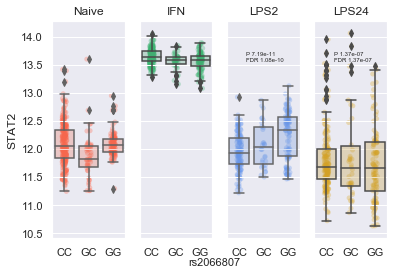

In [5]:
# Plot
colors = ['tomato', 'mediumseagreen', 'cornflowerblue', 'goldenrod']
context = ['Naive', 'IFN', 'LPS2', 'LPS24']
major_allele = 'C'
if a1 == major_allele:
    order = [a1 + a1, a1 + a2, a2 + a2]
else:
    order = [a2 + a2, a1 + a2, a1 + a1]

fig, axes = plt.subplots(ncols=4, sharex=True, sharey=True)
for ax in axes:
    i = list(axes).index(ax)
    grp = context[i]
    f = sns.stripplot(x=snp, y=gene, data=exp_df[exp_df['Context'] == grp], ax=ax, color=colors[i], alpha=0.3, zorder=0, order=order)
    g = sns.boxplot(x=snp, y=gene, data=exp_df[exp_df['Context'] == grp], ax=ax, color=colors[i], order=order)
    for patch in g.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))
    ax.set_title(grp)
    ax.set_xlabel('')
    if i > 0:
        ax.set_ylabel('')
    if i == 2:
        p_value = format(7.185951e-11, '.3g')
        FDR = format(1.07789265e-10, '.3g')
        ax.text(0.3, 13.55, 'P ' + p_value + '\nFDR ' + FDR, fontsize=6)
    if i == 3:
        p_value = format(1.372707e-07, '.3g')
        FDR = format(1.372707e-07, '.3g')
        ax.text(0.3, 13.55, 'P ' + p_value + '\nFDR ' + FDR, fontsize=6)
fig.text(0.5, 0.04, snp, ha='center', va='center', fontsize=11)  # Add overall x-axis label
plt.show()